<a href="https://colab.research.google.com/github/HakujouRyu/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

## Set-up


In [2]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 19.30 MiB | 14.36 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 112kB 17.0MB/s 
     |████████████████████████████████| 133kB 25.0MB/s 
     |████████████████████████████████| 57.7MB 80.5MB/s 
     |████████████████████████████████| 235kB 35.3MB/s 
     |████████████████████████████████| 614kB 38.8MB/s 
     |████████████████████████████████| 235kB 35.1MB/s 
     |████████████████████████████████| 307kB 41.7MB/s 
     |████████████████████████████████| 215kB 48.3MB/s 
     |████████████████████████████████| 51kB 17.8MB/s 
     |████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

## Assignment


### Importing

In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Peek

In [78]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [79]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [80]:
df.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,23040.000000,23040.000000,0.0,23039.000000,23039.000000,23039.000000,23039.000000,2.303900e+04,23005.000000,23040.000000,2.304000e+04
mean,4459.116493,353.948481,NaN,10791.186987,1.827423,0.286514,2.320891,3.508555e+03,1819.671724,1.624479,1.328133e+06
std,3713.269887,628.025255,NaN,1103.414210,10.090432,5.778224,12.070554,2.218610e+04,488.376571,0.803898,1.025394e+07
min,1.000000,1.000000,NaN,0.000000,0.000000,-148.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000e+00
25%,1341.000000,22.000000,NaN,10306.000000,0.000000,0.000000,1.000000,4.940000e+02,1920.000000,1.000000,0.000000e+00
50%,3546.000000,49.000000,NaN,11211.000000,1.000000,0.000000,1.000000,1.356000e+03,1940.000000,1.000000,4.550000e+05
75%,6673.750000,375.000000,NaN,11360.000000,2.000000,0.000000,2.000000,2.280000e+03,1965.000000,2.000000,8.750000e+05
max,16350.000000,9057.000000,NaN,11697.000000,750.000000,570.000000,755.000000,1.303935e+06,2019.000000,4.000000,8.500000e+08


In [81]:
#EASE-MENT is empty! Drop it.
#Is anything else?
df.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [0]:
#We'll deal with the rest later
df = df.drop(columns=['EASE-MENT'])

In [39]:
pandas_profiling.ProfileReport(df)
#our categoricals - ADDRESS, APARTMENT_NUMBER, BOROUGH, BUILDING_CLASS_AT_PRESENT, BUILDING_CLASS_AT_TIME_OF_SALE, BUILDING_CLASS_CATEGORY, LAND_SQUARE_FEET, NEIGHBORHOOD, TAX_CLASS_AT_PRESENT, TAX_CLASS_AT_TIME_OF_SALE

### DF2 Set up
- Let's set up the required DF 
- convert to datetime
- test/train split

In [0]:
#Lets set up the required DF
df2 = df[(df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000)]

In [361]:
df2['SALE_DATE'] = pd.to_datetime(df2['SALE_DATE'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Got a warning, but it worked.

In [363]:
df2['SALE_DATE'] = df2['SALE_DATE'].dt.month.astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [364]:
df2['SALE_DATE'].head()

44    1
61    1
66    1
67    1
71    1
Name: SALE_DATE, dtype: int64

In [0]:
train = df2[df2['SALE_DATE'] < 4]

In [0]:
test = df2[df2['SALE_DATE'] == 4]

In [367]:
train['SALE_DATE'].value_counts()

1    3701
3    3567
2    3174
Name: SALE_DATE, dtype: int64

In [368]:
test['SALE_DATE'].value_counts()

4    2969
Name: SALE_DATE, dtype: int64

### Feature engineering

#### Cardinality Reduction
- make and test function

In [0]:
categoricals = 'ADDRESS, APARTMENT_NUMBER, BOROUGH, BUILDING_CLASS_AT_PRESENT, BUILDING_CLASS_AT_TIME_OF_SALE, BUILDING_CLASS_CATEGORY, LAND_SQUARE_FEET, NEIGHBORHOOD, TAX_CLASS_AT_PRESENT, TAX_CLASS_AT_TIME_OF_SALE'.split(', ')

In [289]:
categoricals

['ADDRESS',
 'APARTMENT_NUMBER',
 'BOROUGH',
 'BUILDING_CLASS_AT_PRESENT',
 'BUILDING_CLASS_AT_TIME_OF_SALE',
 'BUILDING_CLASS_CATEGORY',
 'LAND_SQUARE_FEET',
 'NEIGHBORHOOD',
 'TAX_CLASS_AT_PRESENT',
 'TAX_CLASS_AT_TIME_OF_SALE']

In [0]:
#Let's play around and see if we can loop over above example of reducing cardinality.

def cardinal_reduction(df, columns):
    for col in columns:
        top10 = df[col].value_counts()[:20].index.to_list()
        df.loc[~df[col].isin(top10), col] = 'OTHER'

# Get a list of the top 10 neighborhoods
# top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
# df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

##### Function testing
- didn't work as intended

In [0]:
func_test = df2.copy()


In [0]:
cardinal_reduction(func_test, categoricals)

In [258]:
func_test.shape

(13411, 20)

##### Debugging

In [0]:
test_list = func_test['APARTMENT_NUMBER'].value_counts()[:10].index.to_list()
#Needed to add .index.to_list()

In [141]:
test_list

['3A', '2A', '3', '1', '4B', '2B', '4', '2', '3B', '1A']

In [0]:
func_test.loc[~func_test['APARTMENT_NUMBER'].isin(test_list), 'APARTMENT_NUMBER'] = 'OTHER'

In [178]:
func_test['APARTMENT_NUMBER'].value_counts()

3A       58
2A       58
3        47
1        47
4B       47
2B       46
4        44
2        41
3B       40
1A       38
1B       38
2C       34
5A       30
4A       30
3C       26
5B       26
4C       25
6B       24
3D       23
5D       22
3F       22
2D       20
6        20
5        18
4E       18
1D       18
4F       17
1C       17
4D       17
7A       15
         ..
524C      1
C-11      1
208       1
A615      1
19G       1
4401      1
M4        1
GAR9      1
N805      1
600       1
1S        1
ST-7      1
B506      1
2A-2      1
16J       1
17973     1
206O      1
8P        1
16D       1
PC16      1
4-A       1
L3        1
CA        1
6330      1
88-2A     1
1R/RE     1
N804      1
C202      1
315       1
50E       1
Name: APARTMENT_NUMBER, Length: 1018, dtype: int64

In [180]:
func_test['APARTMENT_NUMBER'].value_counts()

OTHER    12945
3A          58
2A          58
1           47
4B          47
3           47
2B          46
4           44
2           41
3B          40
1A          38
Name: APARTMENT_NUMBER, dtype: int64

In [181]:
func_test['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

OTHER    2885
D4       2735
R4       1749
A1       1186
A5        985
B2        815
B1        721
C0        657
B3        599
C6        586
A2        493
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [0]:
#NOW IT WOORKS!

#### Encoding
- test encoding

In [0]:
func_test = pd.get_dummies(func_test, columns=categoricals)

In [264]:
func_test.head()

,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,SALE_PRICE,SALE_DATE,ADDRESS_1033 EAST 225 STREET,ADDRESS_46-12 30TH ROAD,ADDRESS_57 CHESTNUT STREET,"ADDRESS_62-98 SAUNDERS STREET, 6H",ADDRESS_761 EAST 2ND STREET,ADDRESS_N/A ALBERT ROAD,ADDRESS_N/A BAY STREET,ADDRESS_N/A HURON STREET,ADDRESS_N/A MELBA STREET,ADDRESS_N/A SEAGIRT COURT,ADDRESS_OTHER,APARTMENT_NUMBER_OTHER,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_B1,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_B3,BUILDING_CLASS_AT_PRESENT_C0,BUILDING_CLASS_AT_PRESENT_C6,BUILDING_CLASS_AT_PRESENT_D4,BUILDING_CLASS_AT_PRESENT_OTHER,BUILDING_CLASS_AT_PRESENT_R4,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A2,...,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_OTHER,LAND_SQUARE_FEET_0,"LAND_SQUARE_FEET_1,600","LAND_SQUARE_FEET_1,800","LAND_SQUARE_FEET_2,000","LAND_SQUARE_FEET_2,200","LAND_SQUARE_FEET_2,400","LAND_SQUARE_FEET_2,500","LAND_SQUARE_FEET_3,000","LAND_SQUARE_FEET_4,000","LAND_SQUARE_FEET_5,000",LAND_SQUARE_FEET_OTHER,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_UPPER WEST SIDE (79-96),TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1A,TAX_CLASS_AT_PRESENT_1B,TAX_CLASS_AT_PRESENT_1C,TAX_CLASS_AT_PRESENT_1D,TAX_CLASS_AT_PRESENT_2,TAX_CLASS_AT_PRESENT_2A,TAX_CLASS_AT_PRESENT_2B,TAX_CLASS_AT_PRESENT_2C,TAX_CLASS_AT_PRESENT_4,TAX_CLASS_AT_TIME_OF_SALE_1,TAX_CLASS_AT_TIME_OF_SALE_2,TAX_CLASS_AT_TIME_OF_SALE_4
44,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,550000,2019-01-01,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
61,7918,72,11427.0,1.0,0.0,1.0,2001.0,1940.0,200000,2019-01-01,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
66,1347,18,10022.0,0.0,0.0,0.0,0.0,1960.0,330000,2019-01-02,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
67,1491,62,10075.0,0.0,0.0,0.0,0.0,1925.0,600000,2019-01-02,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
71,1171,2200,10069.0,1.0,0.0,1.0,827.0,2004.0,1250000,2019-01-02,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### Feature Function

In [0]:
# def Wrangle(df, categorical_cols):
#     cardinal_reduction(df, categorical_cols)
#     df = pd.get_dummies(df, columns=categorical_cols)

In [0]:
# Wrangle(test, categoricals)
# Wrangle(train, categoricals)

In [369]:
cardinal_reduction(train, columns=categoricals)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
train = pd.get_dummies(train, columns=categoricals)

In [371]:
train.shape

(10442, 145)

In [372]:
cardinal_reduction(test, columns=categoricals)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
test = pd.get_dummies(test, columns=categoricals)

In [374]:
test.isna().sum().nlargest(10)

YEAR_BUILT           17
BLOCK                 0
LOT                   0
ZIP_CODE              0
RESIDENTIAL_UNITS     0
COMMERCIAL_UNITS      0
TOTAL_UNITS           0
GROSS_SQUARE_FEET     0
SALE_PRICE            0
SALE_DATE             0
dtype: int64

In [0]:
#Get rid of those

In [0]:
test = test.dropna()

In [0]:
test = test.drop(columns='APARTMENT_NUMBER_OTHER')

In [0]:
train = train.drop(columns='APARTMENT_NUMBER_OTHER')

In [0]:
train = train.dropna()

In [0]:
X_train = train.drop(columns='SALE_PRICE')

In [0]:
y_train = train['SALE_PRICE']

In [0]:
X_test = test.drop(columns='SALE_PRICE')

In [0]:
y_test = test['SALE_PRICE']

#### Feature Selection

In [384]:

# Similar API to what we've seen before
selector = SelectKBest(score_func=f_regression, k=15)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

((10437, 15), (2952, 15))

In [0]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = np.sqrt(mean_squared_error(y_test, ridge_reg_split.predict(X_test)))
    # print(alpha, Rmse)
    alphas.append(alpha)
    mses.append(mse)

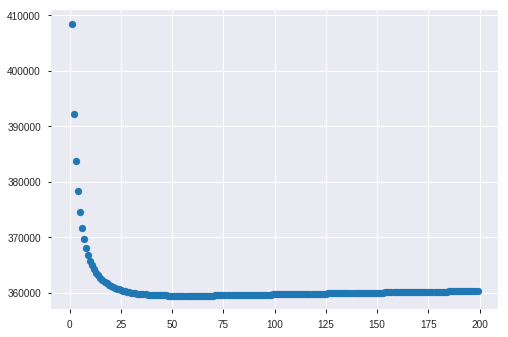

In [395]:
plt.scatter(alphas[1:],mses[1:])